# **Tensorflow: Engineering a Kerr-based Deterministic Cubic Phase Gate via Gaussian Operations in Strawberry Fields**

[Tutorial: SF and Optimization](https://strawberryfields.ai/photonics/demos/run_tutorial_machine_learning.html)

In [3]:
import strawberryfields as sf
from strawberryfields.ops import *
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Optionally, adjust the TensorFlow logger level as well
tf.get_logger().setLevel('ERROR')

Flow:
1) set $\alpha$
2) calculate parameters based on $\alpha$
3) run program
4) get error
5) backpropagate

In [4]:
# defining constant parameters
N = tf.constant(5)
cutoff_dim = 60
_gamma = 0.7
_lamdB = 8.0
backend = "tf"


""" What we change """
# Cubic Phase Gate
gamma = tf.constant(_gamma, dtype=tf.float32)  # target gate angle
# Squeezing
lamdB = tf.constant(_lamdB, dtype=tf.float32)  # squeezing level in dB
# Nonlinearity
chi = tf.constant(0.1, dtype=tf.float32)  # nonlinearity strength

""" The variable """
# Displacement
tf_alpha = tf.Variable(1.4, dtype=tf.float32)  # displacement amplitude

""" Define operations """
def get_params(alpha):
    """ what gets changed """
    lam = tf.sqrt(tf.pow(10.0, lamdB / 10.0))     # squeezing parameter
    rsq = -tf.math.log(lam)                       # squeezing parameter in r form
    sqphi = tf.constant(0.0, dtype=tf.float32)

    # Displacement
    rd = tf.abs(alpha)                              # displacement amplitude in r form
    phi = tf.constant(0.0, dtype=tf.float32)

    # Parameters evolving from alpha
    detuning = 3.0 * chi * tf.pow(alpha, 2) - chi  # detuning for the cubic phase gate
    drive = -2.0 * chi * tf.pow(alpha, 3)          # drive for the cubic phase gate

    # Gate time calculations
    t = tf.sqrt(2.0) * gamma / (chi * alpha * tf.pow(lam, 3))
    dt = t / tf.cast(N, dtype=tf.float32)

    # Parameters for the cubic phase gate step
    nkappa = (chi / 2.0) * dt    # for Kerr gate
    nkerrr = (-chi / 2.0) * dt   # rotation for Kerr operator
    nrphi = -detuning * dt       # for second rotation
    nr = drive * dt              # magnitude of displacement in nonlinear step
    ndphi = tf.constant(3 * np.pi / 2, dtype=tf.float32)  # direction angle for displacement
    
    return rsq, sqphi, rd, phi, nkappa, nkerrr, nrphi, nr, ndphi

In [5]:
""" Find ground truth """
# Build the target program (ideal cubic phase gate)
prog_target = sf.Program(1)
with prog_target.context as q:
    Vgate(_gamma) | q[0]

eng_target = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})

# get target parameters
target_state = eng_target.run(prog_target).state
target_ket_norm = target_state.ket() / tf.norm(target_state.ket())
target_conj = tf.math.conj(target_ket_norm)


""" Define loss """
def loss_fn0(simstate):
    return simstate.fock_prob([1])

def loss_fn1(simstate):
    diff = simstate.ket() - target_state.ket()
    return tf.cast(tf.math.real(tf.norm(diff)), tf.float32)

def loss_fn2(simstate):
    return 1 - tf.math.real(simstate.fidelity(target_state.ket(), mode=0))

def loss_fn(simstate):
    # Normalize the simulated state
    simstate_ket_norm = simstate.ket() / tf.norm(simstate.ket())
    # Compute the inner product and then its magnitude
    inner_prod = tf.tensordot(target_conj, simstate_ket_norm, axes=1)
    return 1 - tf.cast(tf.math.abs(inner_prod), tf.float32) # 1 - |<psi|phi>|


In [6]:
print(loss_fn(target_state))

tf.Tensor(-2.3841858e-07, shape=(), dtype=float32)


In [7]:
def train(set_lamdB):
    global lamdB, tf_alpha
    """ Set / initialize / redefine parameters """
    lamdB = tf.constant(set_lamdB, dtype=tf.float32)  # squeezing level in dB
    tf_alpha = tf.Variable(1.4, dtype=tf.float32)  # displacement amplitude
    
    
    """ Hyperparameters and Initialization """
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    steps = 100

    err_list = []	 # list to store errors

    """ Initialize the engine and program objects """
    # initialize engine and program objects
    eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})
    prog = sf.Program(1)

    # define parametrization of circuit - these are all parameters that in some way depend on alpha
    rsq, sqphi, rd, phi, nkappa, nkerrr, nrphi, nr, ndphi = prog.params("rsq", "sqphi", "rd", "phi", "nkappa", "nkerrr", "nrphi", "nr", "ndphi")

    # define program - our operations
    with prog.context as q:
            # Direct operations: squeezing then displacement
            Sgate(rsq, sqphi) | q[0]
            Dgate(rd, phi) | q[0]
            
            # Nonlinear step(s)
            for i in range(N):
                Rgate(nkerrr) | q[0]
                Kgate(nkappa) | q[0]
                Rgate(nrphi) | q[0]
                Dgate(nr, ndphi) | q[0]
            
            # Inverse operations: displacement then squeezing
            Dgate(-rd, phi) | q[0]
            Sgate(-rsq, sqphi) | q[0]

    """ Run the optimization """
    for step in tqdm(range(steps)):

        # reset the engine if it has already been executed
        if eng.run_progs:
            eng.reset()

        with tf.GradientTape() as tape:
            # calculate parameters
            rsq, sqphi, rd, phi,nkappa, nkerrr, nrphi, nr, ndphi = get_params(tf_alpha) # forward pass (part 1)
            # execute the engine with calculated parameters
            simstate = eng.run(prog, args={"rsq": rsq, "sqphi": sqphi, "rd": rd, "phi": phi, "nkappa": nkappa, "nkerrr": nkerrr, "nrphi": nrphi, "nr": nr, "ndphi": ndphi}).state # forward pass (part 2)
            
            # calculate loss
            loss = loss_fn(simstate)
            err_list.append(loss.numpy())
            

        gradients = tape.gradient(loss, [tf_alpha])
        opt.apply_gradients(zip(gradients, [tf_alpha]))
        if step % 40 == 0:
            print("Step {}: alpha = {}, loss = {}".format(step, tf_alpha.numpy(), loss.numpy()))
            
    return tf_alpha.numpy(), err_list

In [8]:
lamdBs = np.linspace(8, 10, 1
                     )  # squeezing levels in dB
print(lamdBs)
alphas = []
err_lists = []

for lamdB in lamdBs:
    print("Training for squeezing level: {}".format(lamdB))
    alpha, err_list = train(lamdB)
    alphas.append(alpha)
    err_lists.append(err_list)


[8.]
Training for squeezing level: 8.0


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:04<07:09,  4.34s/it]

Step 0: alpha = 1.4099979400634766, loss = 0.07166403532028198


 41%|████      | 41/100 [00:43<00:55,  1.06it/s]

Step 40: alpha = 1.7594414949417114, loss = 0.06882250308990479


 65%|██████▌   | 65/100 [01:06<00:35,  1.02s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\lukas\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\lukas\AppData\Local\Temp\ipykernel_28276\409627106.py", line 9, in <module>
  File "C:\Users\lukas\AppData\Local\Temp\ipykernel_28276\751376746.py", line 57, in train
  File "c:\Users\lukas\anaconda3\Lib\site-packages\tensorflow\python\eager\backprop.py", line 1066, in gradient
    flat_grad = imperative_grad.imperative_grad(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lukas\anaconda3\Lib\site-packages\tensorflow\python\eager\imperative_grad.py", line 67, in imperative_grad
    return pywrap_tfe.TFE_Py_TapeGradient(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lukas\anaconda3\Lib\site-packages\tensorflow\python\eager\backprop.py", line 148, in _gradient_function
    return grad_fn(mock_op, *out_grads)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

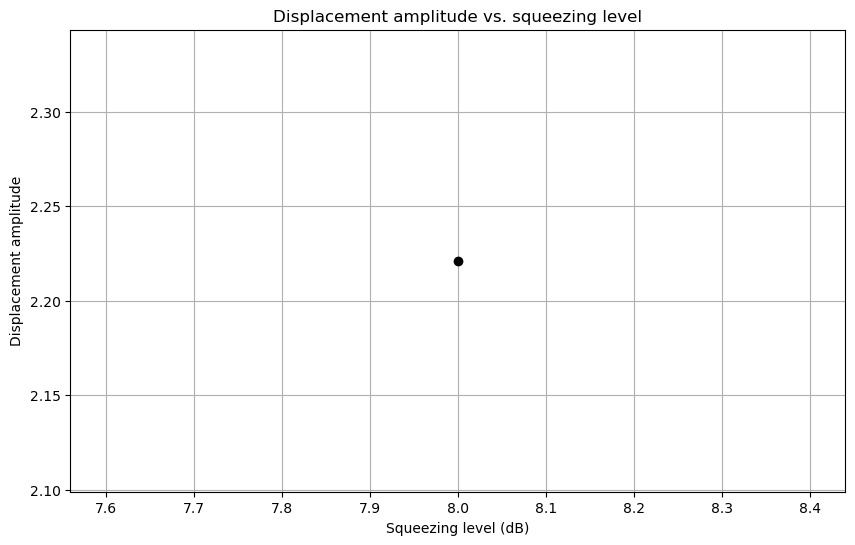

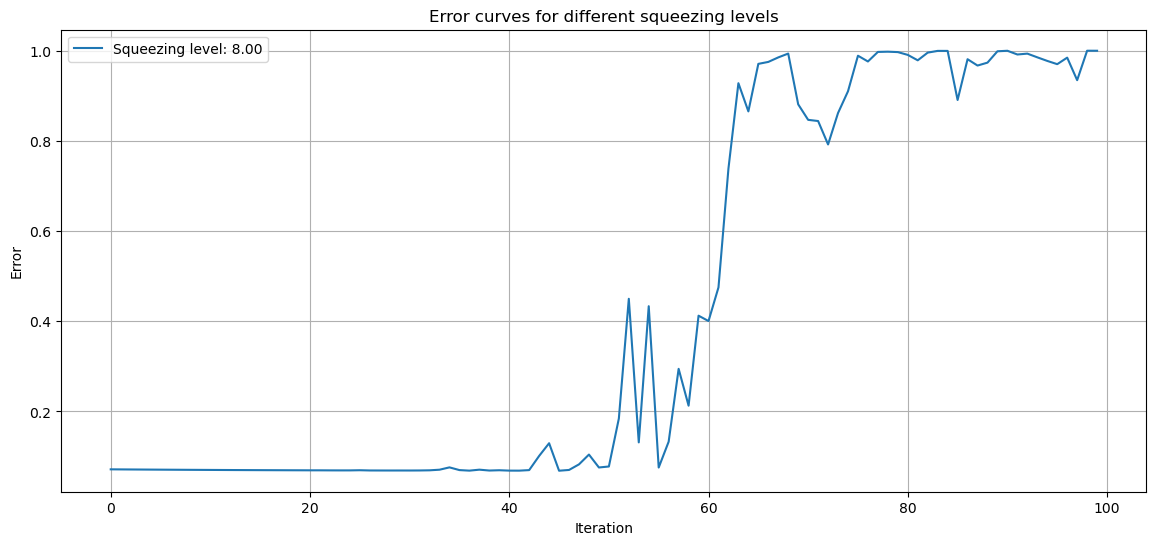

[2.2212105]


In [ ]:
# plot alphas
plt.figure(figsize=(10, 6))
plt.plot(lamdBs, alphas, marker='o', color = 'k')
plt.xlabel("Squeezing level (dB)")
plt.ylabel("Displacement amplitude")
plt.title("Displacement amplitude vs. squeezing level")
plt.grid()
plt.show()

plt.figure(figsize=(14, 6))
# plot error curves
for i, err_list in enumerate(err_lists):
    plt.plot(err_list, label="Squeezing level: {:.2f}".format(lamdBs[i]), color = 'C{}'.format(i))
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Error curves for different squeezing levels")
plt.legend()
plt.grid()
plt.show()

print(alphas)